In [1]:
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
from forgebox.ftorch import FG

In [3]:
fg = FG("wgan")
p = fg.p

==========hyper params==========
{}


### Data Pipeline

In [4]:
train = MNIST("/data/MNIST_TORCH/", train = True, transform=transforms.Compose([transforms.ToTensor()]))
valid = MNIST("/data/MNIST_TORCH/", train = False, transform=transforms.Compose([transforms.ToTensor()]))

In [5]:
from torch import nn
import torch
from torch.utils.data import DataLoader

In [6]:
# next(iter(DataLoader(train)))

In [7]:
CUDA = torch.cuda.is_available()

In [8]:
class G(nn.Module):
    def __init__(self, in_, hs = 1024):
        super().__init__()
        self.in_ = in_
        self.fcb = nn.Sequential(*[
            nn.Linear(in_,hs, ),
            nn.ReLU(),
            nn.Linear(hs,784),
        ])
        
    def forward(self,x):
        x = self.fcb(x)
        return x
    
    def new_images(self, number):
        x = torch.rand(number,self.in_)
        x = self.forward(x)
        return torch.reshape(x,(number,28,28))
    
class D(nn.Module):
    def __init__(self, hs = 1024):
        super().__init__()
        self.hs = hs
        self.fcb = nn.Sequential(*[
            nn.Linear(784,hs),
            nn.ReLU(),
            nn.Linear(hs,1),
        ])
        
    def forward(self,x):
        return self.fcb(x)

In [9]:
from forgebox.ftorch.train import Trainer
from forgebox.ftorch.callbacks import stat

from torch.optim import Adam, RMSprop

In [10]:
trainer = Trainer(dataset=train, batch_size=32, print_on=5,fg=fg, callbacks=[stat])

In [11]:
g,d = G(100,),D()
if CUDA:
    g,d = g.cuda(),d.cuda()
opt_G = RMSprop(g.parameters(),lr= 5e-5)
opt_D = RMSprop(d.parameters(),lr= 5e-5)

trainer.train_G = True
@trainer.step_train
def action(*args, **kwargs):
    if kwargs["ite"] %6 ==5:
        trainer.train_G = True
    else:
        trainer.train_G = False
    opt_G.zero_grad()
    opt_D.zero_grad()
    
    real,y = args[0]
    
    bs = real.size()[0]
    real = torch.reshape(real, (bs,784))
    z = torch.rand(bs, 100)
    
    if CUDA:
        real = real.cuda()
        z = z.cuda()
    fake = g(z)
    x = torch.cat([real,fake], dim=0)
    if trainer.train_G:
        
        loss = - d(fake).mean()
        loss.backward()
        opt_G.step()
    else:
        loss = -(d(real).mean() - d(fake).mean())
        loss.backward()
        opt_D.step()
        for p in d.parameters():
            p.data.clamp_(-0.01, 0.01)
    return {"loss":loss.item()}

In [12]:
trainer.train(6)

,epoch,iter,loss,timestamp
mean,0.0,937.0,-0.284935,0.014568
min,0.0,0.0,-0.765986,0.000000
max,0.0,1874.0,0.328984,27.315877


,epoch,iter,loss,timestamp
mean,1.0,937.0,-0.338347,0.015143
min,1.0,0.0,-1.246994,0.000000
max,1.0,1874.0,0.564624,28.392400


,epoch,iter,loss,timestamp
mean,2.0,937.0,-0.338506,0.013925
min,2.0,0.0,-1.241652,0.000000
max,2.0,1874.0,0.675969,26.108826


,epoch,iter,loss,timestamp
mean,3.0,937.0,-0.265382,0.013510
min,3.0,0.0,-0.973233,0.000000
max,3.0,1874.0,0.498679,25.331449


,epoch,iter,loss,timestamp
mean,4.0,937.0,-0.251376,0.014851
min,4.0,0.0,-0.945594,0.000000
max,4.0,1874.0,0.428594,27.846222


,epoch,iter,loss,timestamp
mean,5.0,937.0,-0.258993,0.016326
min,5.0,0.0,-0.934141,0.000000
max,5.0,1874.0,0.471103,30.611709


In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
images = g.new_images(10)
if CUDA: images = images.cpu()

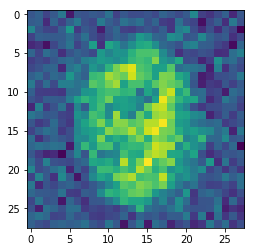

In [15]:
plt.imshow(images.data.numpy()[0])

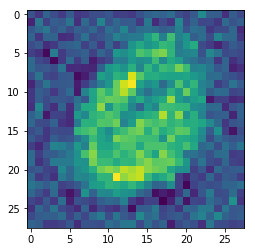

In [16]:
plt.imshow(images.data.numpy()[1])

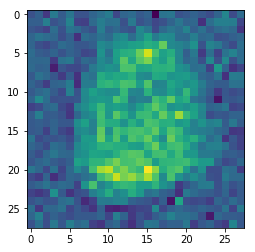

In [17]:
plt.imshow(images.data.numpy()[2])

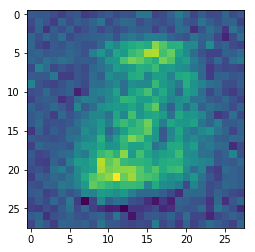

In [18]:
plt.imshow(images.data.numpy()[3])

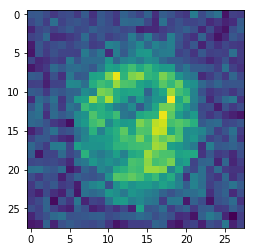

In [19]:
plt.imshow(images.data.numpy()[4])